In [1]:
import subprocess
import os
from ase.io import read
from ase.io.cube import read_cube
from ase.visualize import view
from ase.io import write
from ase.build import surface
import ase.calculators.castep
import ase.io.castep
import pandas as pd
from ase import Atom
from ase import Atoms

from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter, DosPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from python_functions import *
from bs_plotting import *
from castep_output_class import *
from optados_output_class import *
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from python_functions import *
from calculation_class import *
from constants import *
#from ../../modules_codes/script_share/python/bs_plotter_felix_mod import *


In [ ]:
data = {}
for i in range(10):
    data[i+1] = OptaDOSOutput(Path(f'./OD_debug_files/1Step_Testing/Cu_conv/Cu_conv_base_test_{i+1}.odo')).get_totals()
data

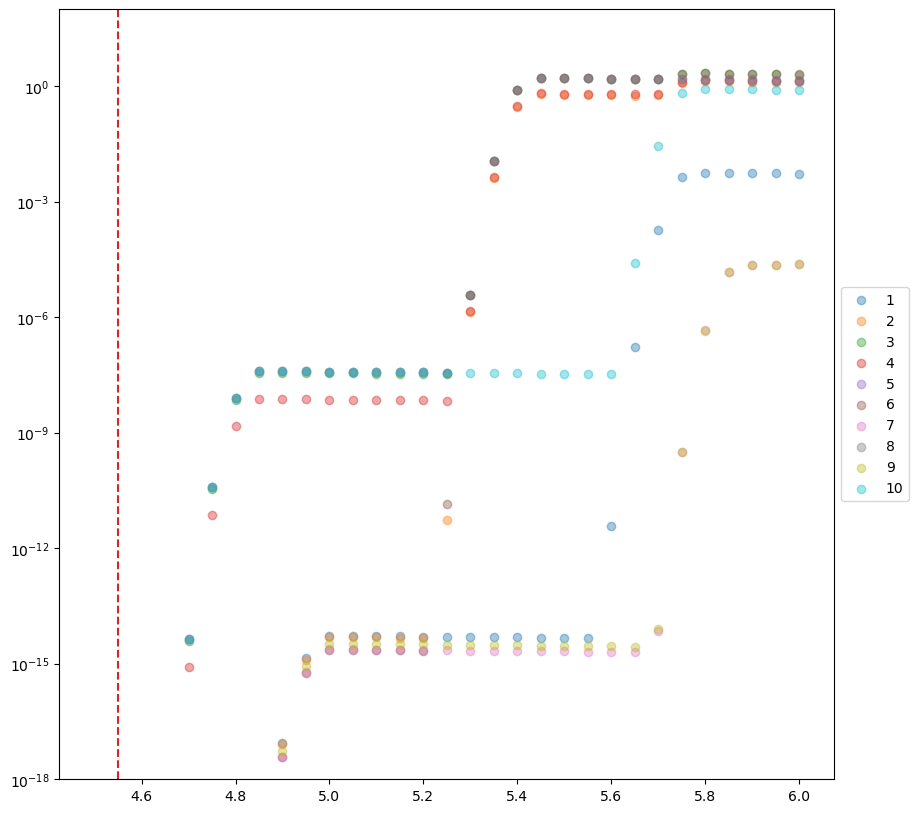

In [26]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
for entry in data.items():
    # print(entry)
    ax.scatter(entry[1][:,0],entry[1][:,1],label=f'{entry[0]}',marker='o',alpha=0.4)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale('log')
limits = [1E-18,1E2]
ax.set_ylim(limits)
ax.vlines([4.55],ymin=limits[0],ymax=limits[1],color='tab:red',linestyles='--')

In [3]:
data = {}
data[1] = OptaDOSOutput(Path(f'./OD_debug_files/1Step_Testing/Cu100_64x64/Cu100_mp_4.3_6.0.odo')).get_totals()
# data[2] = OptaDOSOutput(Path(f'./OD_debug_files/1Step_Testing/Cu100_64x64/Cu100_mp_2.odo')).get_totals()
# data[3] = OptaDOSOutput(Path(f'./OD_debug_files/1Step_Testing/Cu100_64x64/Cu100_mp_3.odo')).get_totals()
mte = OptaDOSOutput(Path(f'./OD_debug_files/1Step_Testing/Cu100_64x64/Cu100_mp_4.3_6.0.odo')).get_mtes()
# mte2 = OptaDOSOutput(Path(f'./OD_debug_files/1Step_Testing/Cu100_64x64/Cu100_mp_2.odo')).get_mtes()
# mte3 = OptaDOSOutput(Path(f'./OD_debug_files/1Step_Testing/Cu100_64x64/Cu100_mp_3.odo')).get_mtes()


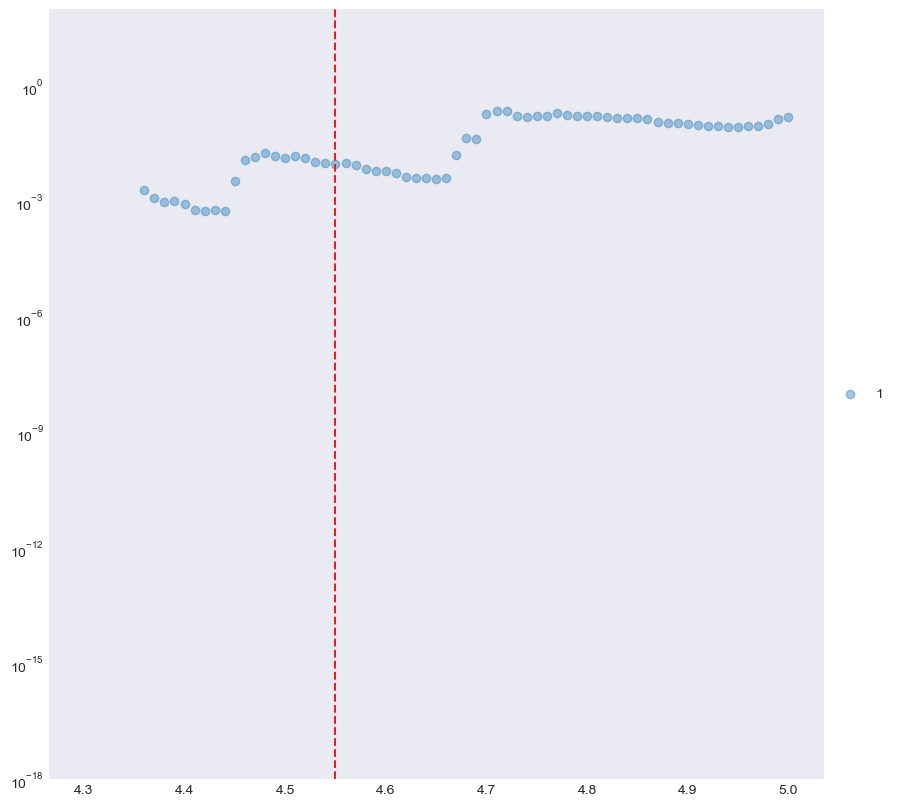

In [48]:

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(mte[:,0],mte[:,1],label=f'{1}',marker='o',alpha=0.4)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale('log')
limits = [1E-18,1E2]
ax.set_ylim(limits)
ax.vlines([4.55],ymin=limits[0],ymax=limits[1],color='tab:red',linestyles='--')

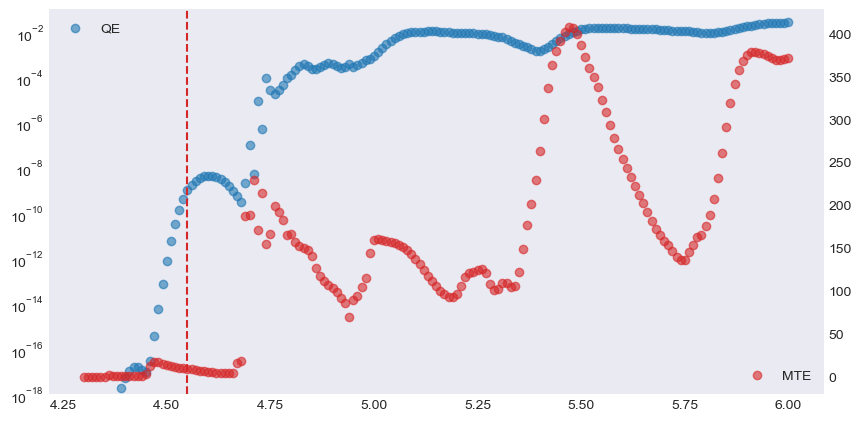

In [4]:
plt.style.use('seaborn-v0_8-dark')
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax2 = ax.twinx()
ax.scatter(data[1][:,0],data[1][:,1],label='QE',marker='o',alpha=0.6,c='tab:blue')
# ax.scatter(data[2][:,0],data[2][:,1],label='QE_2',marker='o',alpha=0.6,c='tab:orange')
# ax.scatter(data[3][:,0],data[3][:,1],label='QE_3',marker='o',alpha=0.6,c='tab:green')
ax2.scatter(mte[:,0],mte[:,1]*1000,marker='o',alpha=0.6,label='MTE',c='tab:red')
# ax2.scatter(mte2[:,0],mte2[:,1]*1000,marker='o',alpha=0.6,label='MTE_2',c='tab:purple')
# ax2.scatter(mte3[:,0],mte3[:,1]*1000,marker='o',alpha=0.6,label='MTE_3',c='tab:gray')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')
ax.set_yscale('log')
limits = [1E-18,1E-1]
ax.set_ylim(limits)
ax.vlines([4.55],ymin=limits[0],ymax=limits[1],color='tab:red',linestyles='--')
plt.savefig('./OD_debug_files/1Step_Testing/Cu100_new_1step_64x64.png',dpi=150)

In [2]:
def read_qe_matrix_values_qemat(filename:str):
    data = {}
    header = []
    with open(filename,"r") as f:
         for i in range(9):
            header.append(f.readline())
    for line in header:
        if 'Photoemission Model' in line:
            data['model'] = line.split()[3]
        if 'Photon Energy' in line:
            data['energy'] = float(line.split()[3])
        if '## (Reduced) QE Matrix Shape' in line:
            shape = [int(x) for x in line.split()[6:10]]

    matrix = np.genfromtxt(filename,comments='#')
    data['matrix'] = np.reshape(matrix.flatten(order='C'), shape, order = 'F')
    return data;

def read_fe_matrix_values(filename:str):
    data = {}
    header = []
    with open(filename,"r") as f:
         for i in range(9):
            header.append(f.readline())
    for line in header:
        if 'Photoemission Model' in line:
            data['model'] = line.split()[3]
        if 'Photon Energy' in line:
            data['energy'] = float(line.split()[3])
        if '## (Reduced) QE Matrix Shape' in line:
            shape = [int(x) for x in line.split()[6:9]]

    matrix = np.genfromtxt(filename,delimiter=16,comments='#',skip_header=8)
    # print(matrix.shape)
    data['matrix'] = np.reshape(matrix.flatten(order='C'), shape, order = 'F')
    return data;

In [7]:
from optados_plotting_functions import read_bands_file
data_bands = read_bands_file('./OD_debug_files/1Step_Testing/Cu100_64x64_xgmx_bs/Cu100_mp_xgmx_110k.bands')
energies = np.linspace(4.3,6.0,171)
data_matrices = {}
for energy in energies:
    # data_matrices[energy] = read_fe_matrix_values(f'./OD_debug_files/1Step_Testing/Cu100_64x64_xgmx_bs/1step_old_fem_matrices/Cu100_mp_1step_{energy:.3f}_fem_matrix.dat')
    old = read_qe_matrix_values_qemat(f'./OD_debug_files/1Step_Testing/Cu100_64x64_xgmx_bs/1step_old_QE_matrices/Cu100_mp_1step_{energy:.3f}_qe_matrix.dat')
    new = read_qe_matrix_values_qemat(f'./OD_debug_files/1Step_Testing/Cu100_64x64_xgmx_bs/1step_new_QE_matrices/Cu100_mp_1step_{energy:.3f}_qe_matrix.dat')
    data_matrices[energy] = new
    diff = new['matrix'] - old['matrix']
    pos = np.select([diff>0], [diff], default=0)
    neg = np.select([diff<0], [diff], default=0)
    # values = np.abs(now - future)
    data_matrices[energy]['matrix_pos'] = pos
    data_matrices[energy]['matrix_neg'] = np.abs(neg)

In [ ]:
mte_new = OptaDOSOutput(Path('./OD_debug_files/1Step_Testing/'))

In [10]:
for idx in range(0,170):
    now = data_matrices[energies[idx]]['matrix']
    future = data_matrices[energies[idx+1]]['matrix']
    diff = future - now
    pos = np.select([diff>0.0], [diff], default=0.0)
    neg = np.select([diff<0.0], [diff], default=0.0)
    # values = np.abs(now - future)
    data_matrices[energies[idx]]['matrix_pos'] = pos
    data_matrices[energies[idx]]['matrix_neg'] = np.abs(neg)

IndexError: index 171 is out of bounds for axis 0 with size 171

0.0005977763437073675


In [71]:
print(data_matrices[energies[-2]]['matrix'].shape)

(243, 110, 1)


In [11]:
data_matrices[4.55]

{'model': '1step',
 'energy': 4.55,
 'matrix': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...

0.0016495812947364698


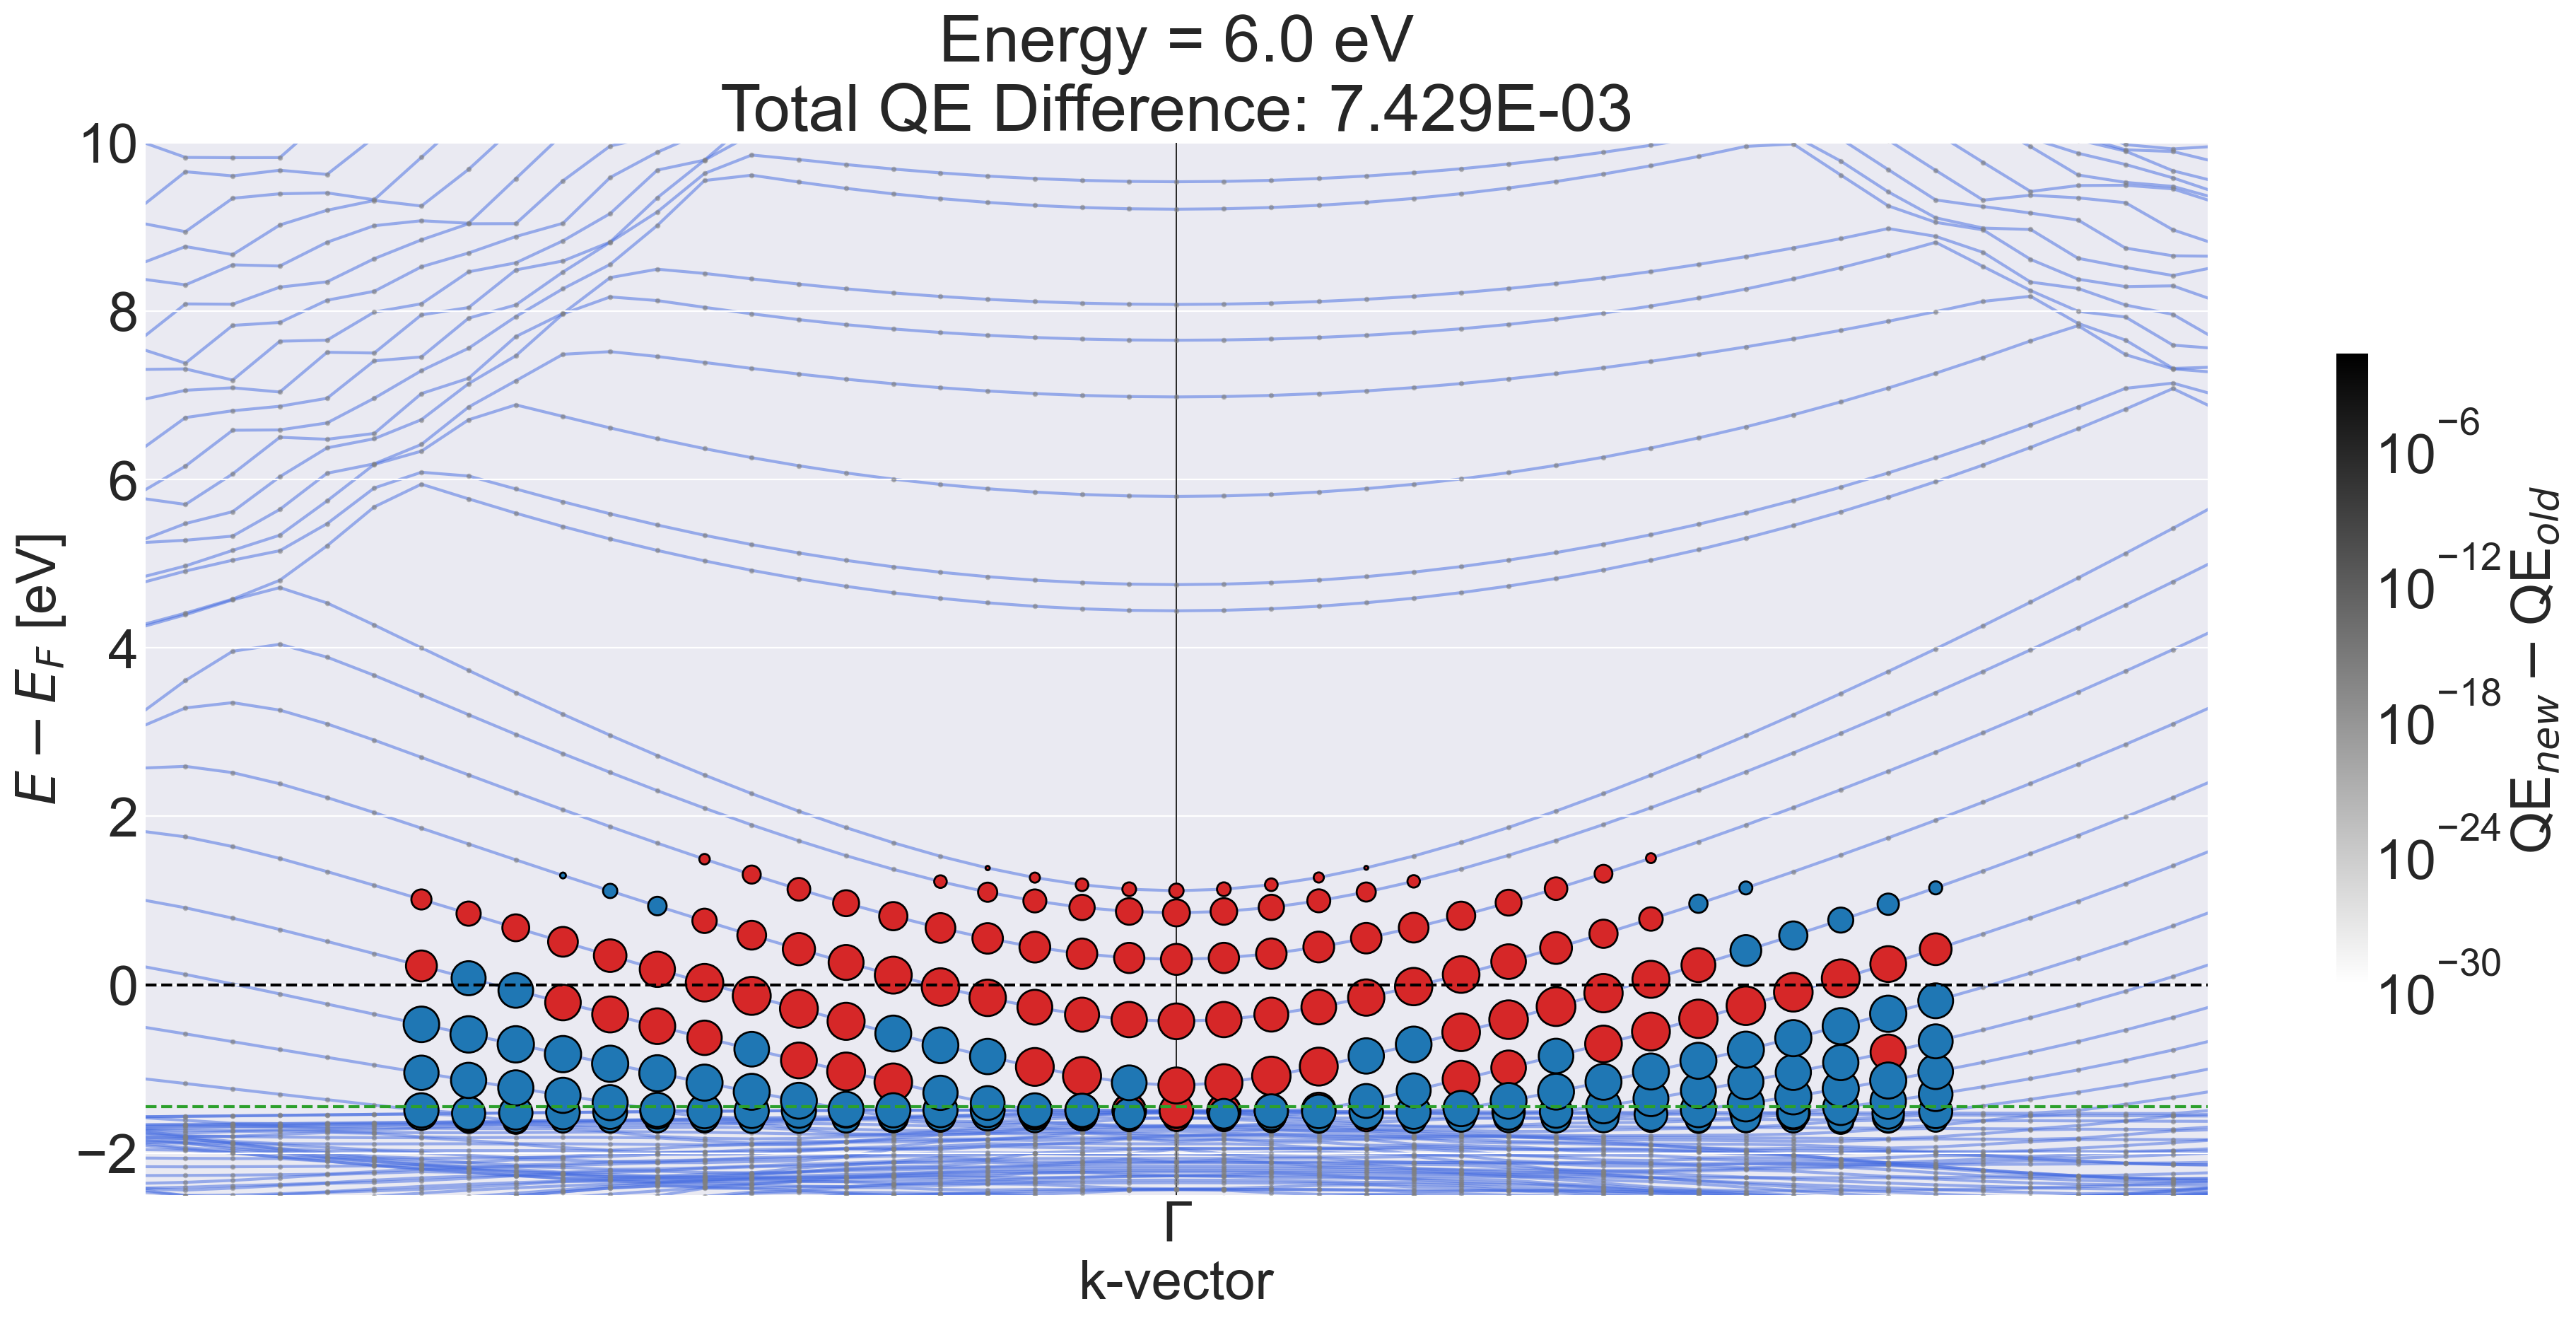

In [12]:
import matplotlib.colors as mlp
import matplotlib as mpl
# %matplotlib widget
from matplotlib.widgets import Slider, Button
from matplotlib.gridspec import GridSpec

# qe_sums(eigenvalues, kpoints, energies)
# band_energies(eigenvalues, kpoints)
# band_distances(eigenvalues, kpoints)
# norms(eigenvalues, kpoints, energies)
# alphas(eigenvalues, kpoints, energies)

# SETTING UP THE DATA STRUCTURES

num_eigen = data_bands['num_eigen']
num_kpts = data_bands['num_kpt']
num_energies = len(energies)
#print(num_layers)

# Setting up all the arrays needed for holding the data
qe_sums_pos = np.zeros((num_eigen,num_kpts, num_energies))
qe_sums_neg = np.zeros((num_eigen,num_kpts, num_energies))
qe_totals_pos = np.zeros((num_energies))
qe_totals_neg = np.zeros((num_energies))
mte_values = np.zeros((num_energies))
band_energies = np.zeros((num_eigen,num_kpts))
band_distances = np.zeros((num_eigen, num_kpts))
norms = np.zeros((num_eigen,num_kpts, num_energies))
scales = np.zeros((num_eigen,num_kpts, num_energies,2))
plt.rcParams.update({'font.size': 28})

# Filling up the created arrays with the respective data
band_energies = np.sum(data_bands['eigenval_efermi_0'],axis=1)
for i in range(num_eigen): band_distances[i,:] =  data_bands['scaled_kpt_path']
for idx,energy in enumerate(energies):
    temp_matrix_pos = data_matrices[energy]['matrix_pos']
    temp_matrix_neg = data_matrices[energy]['matrix_neg']
    for kdx in range(num_kpts):
    # print(temp_matrix.shape)
    # print(np.sum(temp_matrix,axis=(1,3)).shape)
        qe_sums_pos[:,data_bands['order'][kdx],idx] = np.sum(temp_matrix_pos,axis=(1,3))[:,kdx]
        qe_sums_neg[:,data_bands['order'][kdx],idx] = np.sum(temp_matrix_neg,axis=(1,3))[:,kdx]
        # qe_sums[:,data_bands['order'][kdx],idx] = np.sum(temp_matrix,axis=(2))[:,kdx]
    qe_totals_pos[idx] = np.sum(qe_sums_pos[:,:,idx])
    qe_totals_neg[idx] = np.sum(qe_sums_neg[:,:,idx])
    # mte_values[idx] = data_1step_odo[round(energy,2)][1]*1000
    #print(np.shape(np.sum(temp_matrix,axis=(0,1,2))))

# Setting up the normalisations for colors
# non_zero = qe_sums[np.nonzero(qe_sums)]
# vmin_sums = np.nanmin(non_zero)
vmin_sums = 1e-30
# vmax_sums = 1000
vmax_sums_pos = np.nanmax(qe_sums_pos)
vmax_sums_neg = np.nanmax(qe_sums_neg)
print(max(vmax_sums_pos, vmax_sums_neg))
# print(np.nanmin(qe_sums))
# print(vmin_sums, vmax_sums)
norm_sums = mlp.LogNorm(vmin=vmin_sums, vmax=0.009992669658,clip = True)
for idx,energy in enumerate(energies):
    scales[:,:,idx,0] = norm_sums(qe_sums_pos[:,:,idx])*400
    scales[:,:,idx,1] = norm_sums(qe_sums_neg[:,:,idx])*400

fixed_cmap ='binary'

i = 0
imax = len(energies)-1
annotations = {}
# Setting up the figure and its layout
plt.style.use('seaborn-v0_8-darkgrid')
#plt.ion()
fig,ax = plt.subplots(1,1,figsize=(20,10),dpi=200)

# Setting up Graph 1 with bands and contributions
scatter_bands = ax.scatter(band_distances,band_energies,c='grey',marker='.',s=12,alpha = 0.5,zorder=2)
title_bs = ax.set_title(f'Energy = {round(energies[0],2)} eV\nTotal QE Change: {np.sum(qe_sums_pos[:,:,0])-np.sum(qe_sums_neg[:,:,0]):.3E}')
# title_bs = ax.set_title(f'Energy = {round(energies[0],2)} eV')
# fig.suptitle('Final State Contributions')
for i in range(num_eigen):
    ax.plot(band_distances[i,:],band_energies[i,:],c='royalblue',alpha = 0.5,zorder=0)
# a = 94
# ax.plot(band_distances[a,:],band_energies[a,:],c='red',zorder=0)
scatter_qe_contribs_pos = ax.scatter(band_distances,band_energies,c='tab:red',s=scales[:,:,0,0].flatten(), marker='o',zorder=3,edgecolors='k')
scatter_qe_contribs_neg = ax.scatter(band_distances,band_energies,c='tab:blue',s=scales[:,:,0,1].flatten(), marker='o',zorder=3,edgecolors='k')
colorbar_contributions = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sums,cmap= fixed_cmap),ax = ax,orientation='vertical',label = 'QE$_{new}-$QE$_{old}$',shrink=0.6,pad=0.05) #'|$QE_{old}-QE_{new}$|'
# colorbar_contributions = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sums,cmap= fixed_cmap),ax = ax,orientation='vertical',label = 'FE OME',shrink=0.6,pad=0.05)
ekin_max = ax.axhline(y=4.5519-energies[0],color='tab:green',linestyle='--',zorder=4,label='min. $E_{\psi_{i}}$ for emission')
fermi = ax.axhline(y=0,color='black',linestyle='--',zorder=3)
xticks_ax1 = [data_bands['scaled_kpt_path'][0],data_bands['scaled_kpt_path'][32],data_bands['scaled_kpt_path'][77],data_bands['scaled_kpt_path'][-1]]
ax.vlines(xticks_ax1,colors = 'k',ymin = -50,ymax = 50,linewidth=0.6,zorder=1)
ax.set_xticks(xticks_ax1,labels=['X',r'$\Gamma$','M','X'])

ax.set_ylim(-2.5,10)
ax.set_xlim(0.29289321881345254-.2,0.29289321881345254+.2)
ax.set_xlabel('k-vector')
ax.set_ylabel(r'$E - E_F$ [eV]')
# fig.legend()

for i in [170]:
# for i in [int((5.41-4.3)/0.01)]:
    # print(i)
    # scatter_qe_contribs_pos.set_array(qe_sums_pos[:,:,i].flatten())
    scatter_qe_contribs_pos.set_sizes(scales[:,:,i,0].flatten())
    scatter_qe_contribs_pos.set_color('tab:red')
    scatter_qe_contribs_pos.set_edgecolor('k')


    # scatter_qe_contribs_neg.set_array(qe_sums_neg[:,:,i].flatten())
    scatter_qe_contribs_neg.set_sizes(scales[:,:,i,1].flatten())
    scatter_qe_contribs_neg.set_color('tab:blue')
    scatter_qe_contribs_neg.set_edgecolor('k')

    ekin_max.set_ydata([4.5519-energies[i]])
    title_bs.set_text(f'Energy = {round(energies[i],2)} eV\nTotal QE Difference: {np.sum(qe_sums_pos[:,:,i])-np.sum(qe_sums_neg[:,:,i]):.3E}')
    # title_bs.set_text(f'Energy = {energies[i]:.2f} eV')
    plt.tight_layout()
    plt.savefig(f'./OD_debug_files/1Step_Testing/Cu100_64x64_xgmx_bs/QE_Dashboards_difference_zoom_colored/Dashboard_1step_{energies[i]:.2f}.png',dpi=150)

In [55]:
print(data_bands['scaled_kpt_path'][32])

0.29289321881345254


0.009992669658


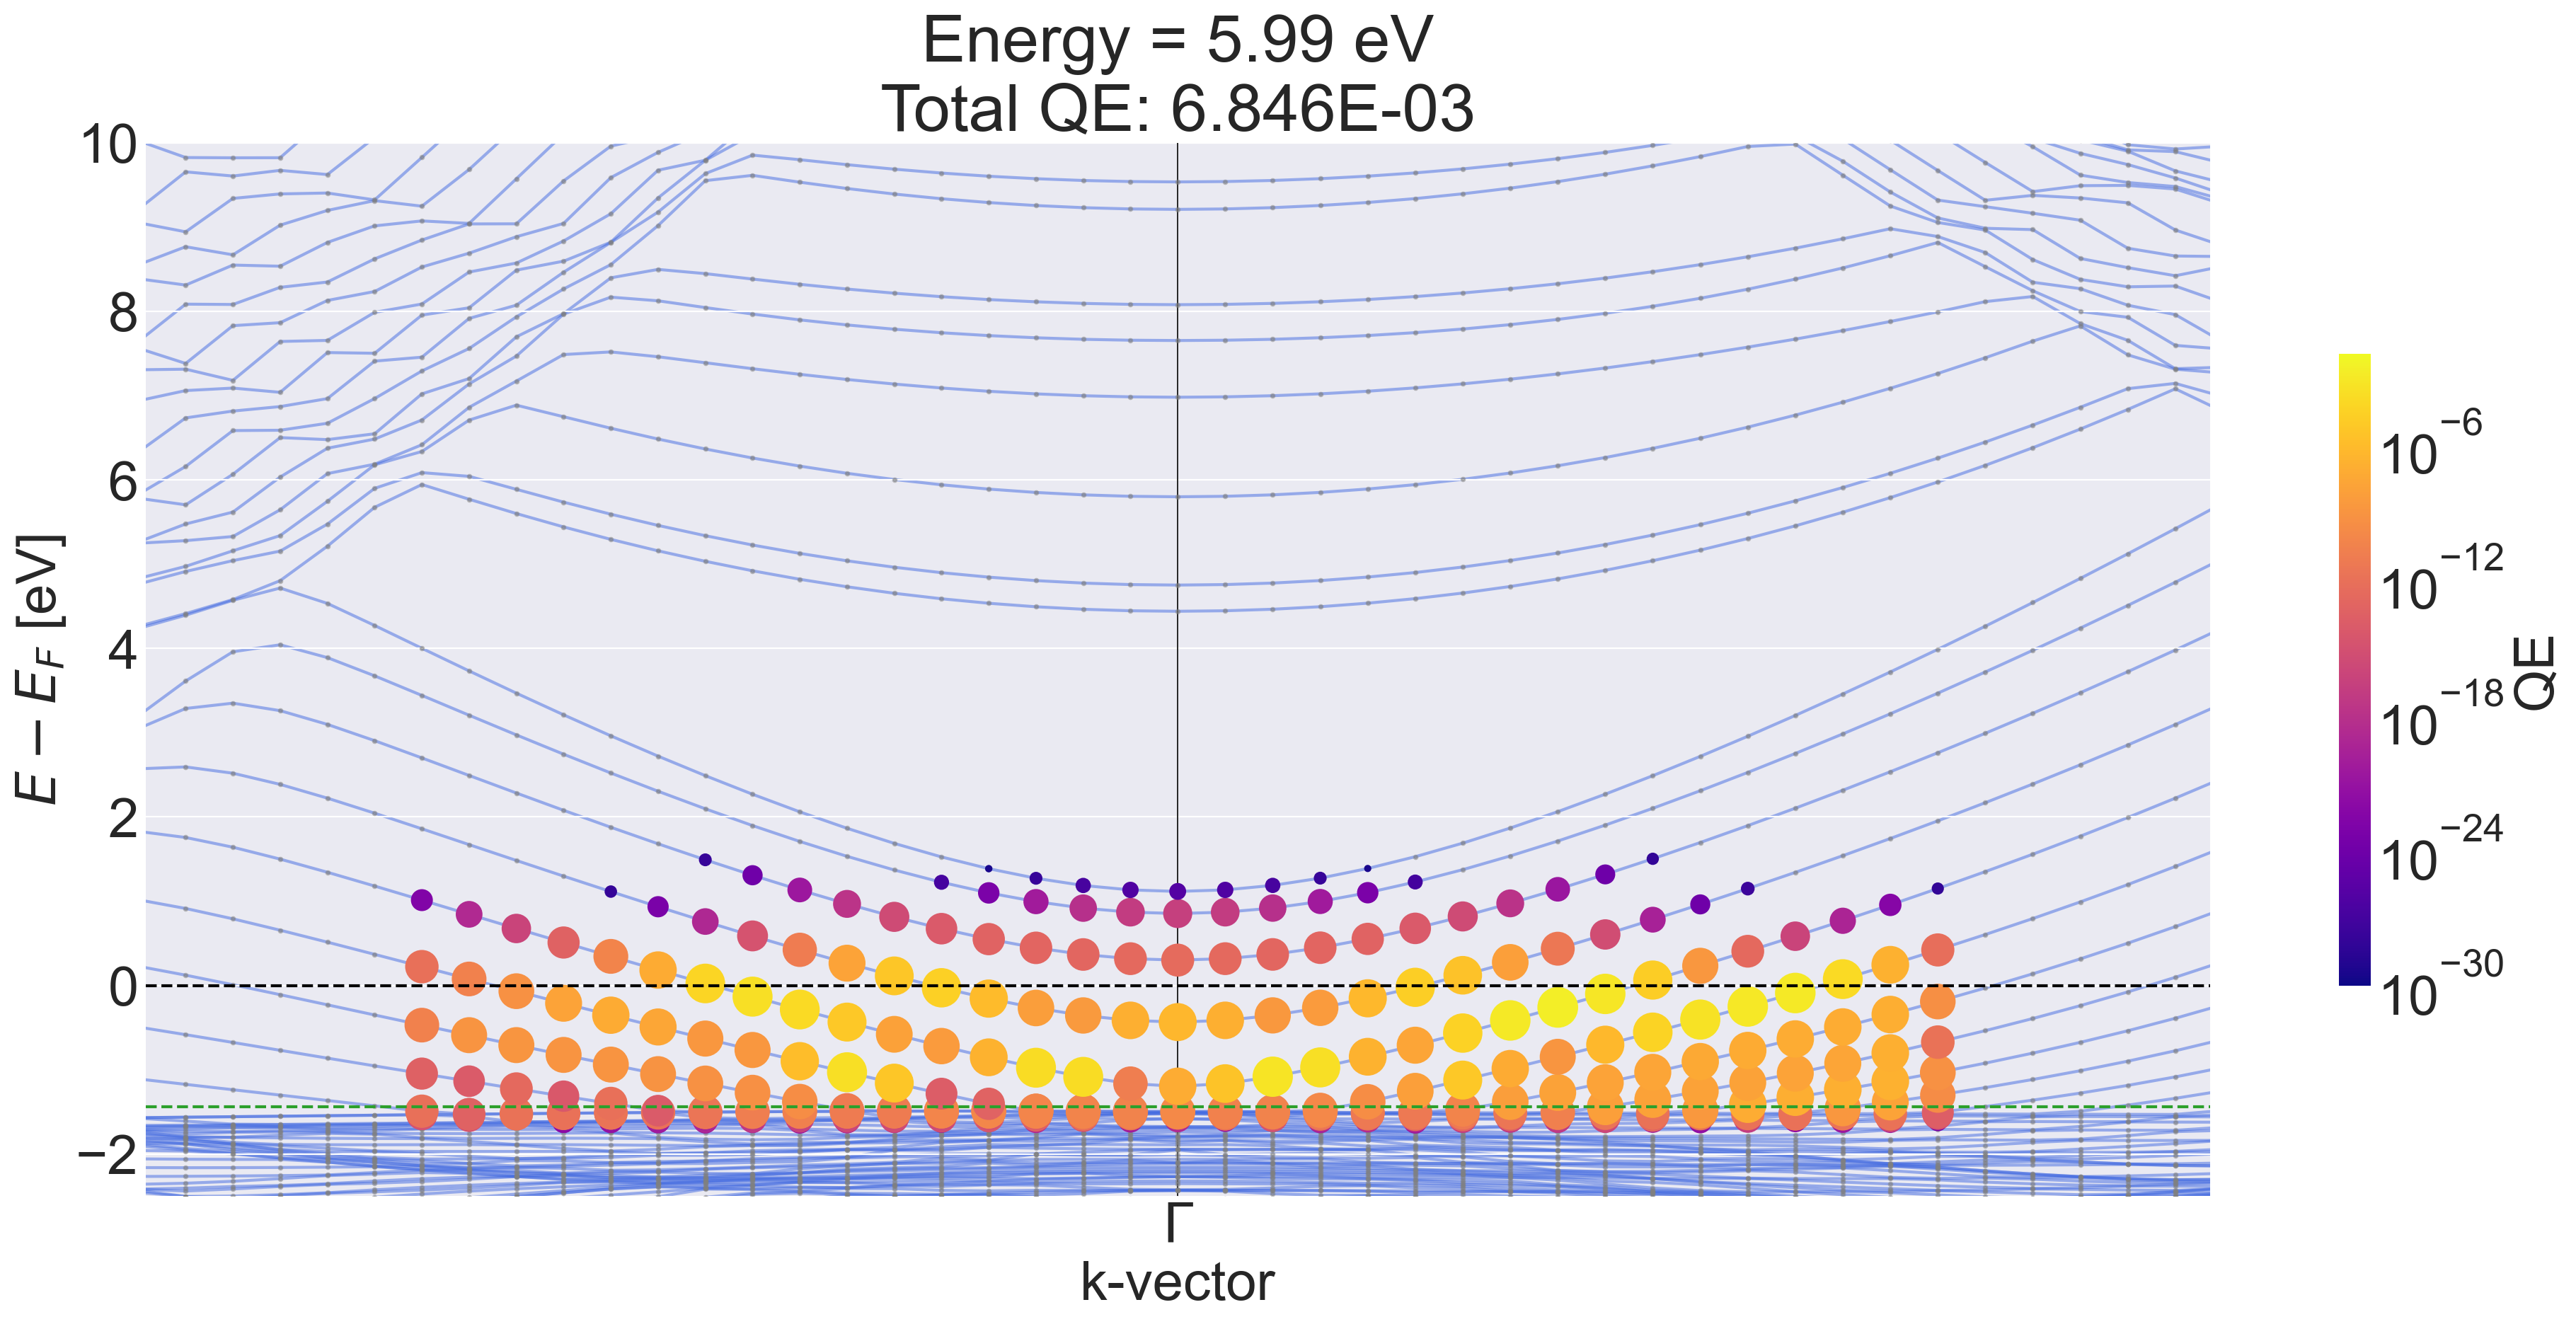

In [67]:
import matplotlib.colors as mlp
import matplotlib as mpl
# %matplotlib widget
from matplotlib.widgets import Slider, Button
from matplotlib.gridspec import GridSpec

# qe_sums(eigenvalues, kpoints, energies)
# band_energies(eigenvalues, kpoints)
# band_distances(eigenvalues, kpoints)
# norms(eigenvalues, kpoints, energies)
# alphas(eigenvalues, kpoints, energies)

# SETTING UP THE DATA STRUCTURES

num_eigen = data_bands['num_eigen']
num_kpts = data_bands['num_kpt']
num_energies = len(energies)
#print(num_layers)

# Setting up all the arrays needed for holding the data
qe_sums = np.zeros((num_eigen,num_kpts, num_energies))
qe_totals = np.zeros((num_energies))
mte_values = np.zeros((num_energies))
band_energies = np.zeros((num_eigen,num_kpts))
band_distances = np.zeros((num_eigen, num_kpts))
norms = np.zeros((num_eigen,num_kpts, num_energies))
scales = np.zeros((num_eigen,num_kpts, num_energies))
plt.rcParams.update({'font.size': 28})

# Filling up the created arrays with the respective data
band_energies = np.sum(data_bands['eigenval_efermi_0'],axis=1)
for i in range(num_eigen): band_distances[i,:] =  data_bands['scaled_kpt_path']
for idx,energy in enumerate(energies):
    temp_matrix = data_matrices[energy]['matrix']
    for kdx in range(num_kpts):
    # print(temp_matrix.shape)
    # print(np.sum(temp_matrix,axis=(1,3)).shape)
        qe_sums[:,data_bands['order'][kdx],idx] = np.sum(temp_matrix,axis=(1,3))[:,kdx]
        # qe_sums[:,data_bands['order'][kdx],idx] = np.sum(temp_matrix,axis=(2))[:,kdx]
    qe_totals[idx] = np.sum(qe_sums[:,:,idx])
    # mte_values[idx] = data_1step_odo[round(energy,2)][1]*1000
    #print(np.shape(np.sum(temp_matrix,axis=(0,1,2))))

# Setting up the normalisations for colors
non_zero = qe_sums[np.nonzero(qe_sums)]
# vmin_sums = np.nanmin(non_zero)
vmin_sums = 1e-30
# vmax_sums = 1000
vmax_sums = np.nanmax(qe_sums)
print(vmax_sums)
# print(np.nanmin(qe_sums))
# print(vmin_sums, vmax_sums)
norm_sums = mlp.LogNorm(vmin=vmin_sums, vmax=vmax_sums,clip = True)
for idx,energy in enumerate(energies):
    scales[:,:,idx] = norm_sums(qe_sums[:,:,idx])*400

fixed_cmap ='plasma'

i = 0
imax = len(energies)-1
annotations = {}
# Setting up the figure and its layout
plt.style.use('seaborn-v0_8-darkgrid')
#plt.ion()
fig,ax = plt.subplots(1,1,figsize=(20,10),dpi=200)

# Setting up Graph 1 with bands and contributions
scatter_bands = ax.scatter(band_distances,band_energies,c='grey',marker='.',s=12,alpha = 0.5,zorder=2)
title_bs = ax.set_title(f'Energy = {round(energies[0],2)} eV\nTotal QE Change: {np.sum(qe_sums[:,:,0]):.3E}')
# title_bs = ax.set_title(f'Energy = {round(energies[0],2)} eV')
# fig.suptitle('Final State Contributions')
for i in range(num_eigen):
    ax.plot(band_distances[i,:],band_energies[i,:],c='royalblue',alpha = 0.5,zorder=0)
# a = 94
# ax.plot(band_distances[a,:],band_energies[a,:],c='red',zorder=0)
scatter_qe_contribs = ax.scatter(band_distances,band_energies,cmap=fixed_cmap,norm=norm_sums,c=qe_sums[:,:,0].flatten(),s=scales[:,:,0].flatten(),marker='o',zorder=3)
# scatter_qe_contribs = ax.scatter(band_distances,band_energies,cmap=fixed_cmap,norm=norm_sums,c=qe_sums[:,:,0].flatten(),s=scales[:,:,0].flatten(),marker='o',zorder=3)
colorbar_contributions = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sums,cmap= fixed_cmap),ax = ax,orientation='vertical',label = 'QE',shrink=0.6,pad=0.05)
# colorbar_contributions = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sums,cmap= fixed_cmap),ax = ax,orientation='vertical',label = 'FE OME',shrink=0.6,pad=0.05)
ekin_max = ax.axhline(y=4.5519-energies[0],color='tab:green',linestyle='--',zorder=4,label='min. $E_{\psi_{i}}$ for emission')
fermi = ax.axhline(y=0,color='black',linestyle='--',zorder=3)
xticks_ax1 = [data_bands['scaled_kpt_path'][0],data_bands['scaled_kpt_path'][32],data_bands['scaled_kpt_path'][77],data_bands['scaled_kpt_path'][-1]]
ax.vlines(xticks_ax1,colors = 'k',ymin = -50,ymax = 50,linewidth=0.6,zorder=1)
ax.set_xticks(xticks_ax1,labels=['X',r'$\Gamma$','M','X'])

ax.set_ylim(-2.5,10)
ax.set_xlim(0.29289321881345254 - 0.2, 0.29289321881345254 + 0.2)
ax.set_xlabel('k-vector')
ax.set_ylabel(r'$E - E_F$ [eV]')
# fig.legend()

for i in range(num_energies,num_energies+1):
# for i in [25]:
    scatter_qe_contribs.set_array(qe_sums[:,:,i].flatten())
    scatter_qe_contribs.set_sizes(scales[:,:,i].flatten())
    ekin_max.set_ydata([4.5519-energies[i]])
    title_bs.set_text(f'Energy = {round(energies[i],2)} eV\nTotal QE: {np.sum(qe_sums[:,:,i]):.3E}')
    # title_bs.set_text(f'Energy = {energies[i]:.2f} eV')
    plt.tight_layout()
    plt.savefig(f'./OD_debug_files/1Step_Testing/Cu100_64x64_xgmx_bs/QE_Dashboards_new_zoom/Dashboard_1step_{energies[i]:.2f}.png',dpi=150)

In [1]:
# importing libraries
import os
import cv2  
  
# Video Generating function
def generate_video(image_folder:str,framerate:float,final_name:str):      
    images = [img for img in os.listdir(image_folder)
            #   if '3step' in img]
              if img.endswith(".png")]
  
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter('temp.avi', 0, framerate, (width, height)) 
  
    # Appending the images to the video one by one
    for image in images: 
        video.write(cv2.imread(os.path.join(image_folder, image))) 
    # Deallocating memories taken for window creation
    cv2.destroyAllWindows() 
    video.release()  # releasing the video generated
    
    os.system(f'ffmpeg -i temp.avi -vcodec libx264 {final_name}.mp4')
    os.system('rm -f temp.avi')

generate_video('./OD_debug_files/1Step_Testing/Cu100_64x64_xgmx_bs/QE_Dashboards_difference_zoom_colored',3,'1step_difference_old_new_diff_colored_BS_XGMX_3fps')